## **Using a Convolutional Neural Network to Identify Cube Rotations.**

In this notebook, I will be using images which I have generated using my Shape3D.py and Blur.py images, found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

I will be using TensorFlow2 and Keras to create a Sequential model which will be trained using the cube images, and then more images will be tested to see if the model can correctly identify their rotations.

The tutorial I followed can be found at https://www.tensorflow.org/tutorials/images/classification.

# Importing the relevant libraries.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

Retrieving images from Google Drive.

In [86]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Nanoparticles/Train 7"
img_size = (231, 232) # Image dimensions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, the images to be used for training must be assigned to the training subset. I will be using 80% to train, and 20% to validate.

In [87]:
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names) # Number of categories

Found 420 files belonging to 4 classes.
Using 336 files for training.


Some of the images to be used by the dataset are shown below.

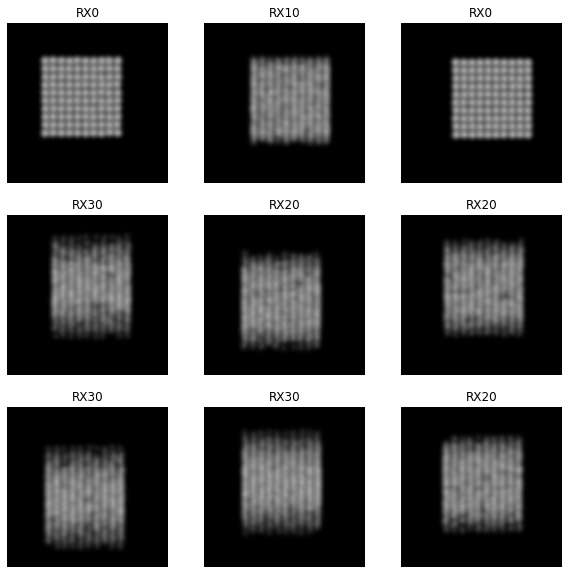

In [88]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Secondly, the images to be used for validation must be assigned.

In [89]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 420 files belonging to 4 classes.
Using 84 files for validation.


Using data augmentation adds some more variety to the training data, thus resulting in a higher accuracy.

In [90]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(*img_size,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Standardizing the data.

In [91]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the model.

In [92]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiling the model.

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 231, 232, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 231, 232, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 231, 232, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 115, 116, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 115, 116, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 57, 58, 32)       0         
 g2D)                                                

# Training the model.

In [94]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
11/11 [==============================] - 39s 3s/step - loss: 1.4660 - accuracy: 0.2411 - val_loss: 1.3798 - val_accuracy: 0.2381
Epoch 2/25
11/11 [==============================] - 21s 2s/step - loss: 1.3834 - accuracy: 0.2262 - val_loss: 1.3702 - val_accuracy: 0.2262
Epoch 3/25
11/11 [==============================] - 21s 2s/step - loss: 1.3652 - accuracy: 0.2530 - val_loss: 1.3171 - val_accuracy: 0.2976
Epoch 4/25
11/11 [==============================] - 21s 2s/step - loss: 1.3142 - accuracy: 0.3304 - val_loss: 1.2140 - val_accuracy: 0.5000
Epoch 5/25
11/11 [==============================] - 21s 2s/step - loss: 1.2016 - accuracy: 0.4345 - val_loss: 1.0437 - val_accuracy: 0.4048
Epoch 6/25
11/11 [==============================] - 21s 2s/step - loss: 1.0399 - accuracy: 0.4494 - val_loss: 0.8075 - val_accuracy: 0.6667
Epoch 7/25
11/11 [==============================] - 21s 2s/step - loss: 0.8940 - accuracy: 0.6161 - val_loss: 0.7756 - val_accuracy: 0.5714
Epoch 8/25
11/11 [==

Visualizing the training results.

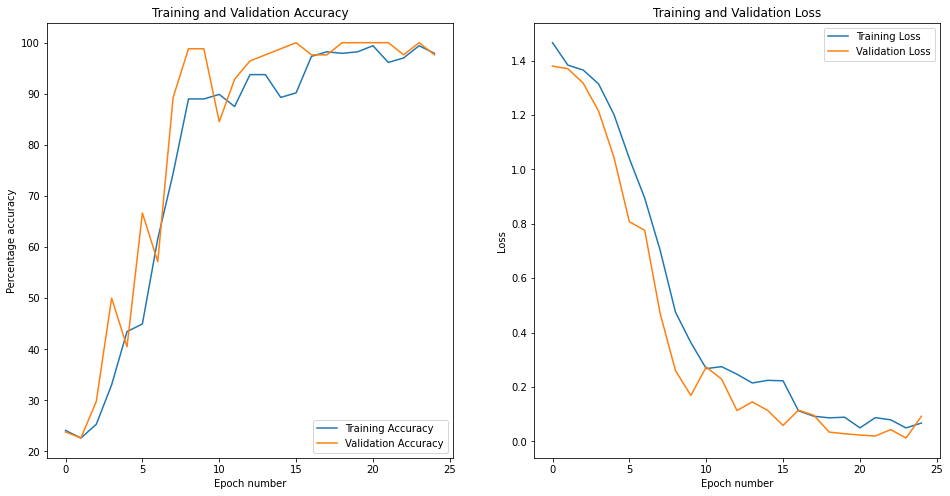

In [100]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

# Predicting an image.

In [96]:
def predict_image(file_path):
  img_path = os.path.join(data_dir, file_path)

  img = tf.keras.utils.load_img(
      img_path, target_size=img_size
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  temp_names = file_path.split("/")[-1].split()
  width, rx = temp_names[0], temp_names[1]
  actual = rx
  predicted = class_names[np.argmax(score)]
  confidence = 100 * np.max(score)

  print(
      "Actual: {} \t| Predicted: {} \t| Confidence: {:.2f}%"
      .format(actual, predicted, confidence)
  )

  return [actual, rx==predicted, confidence]

In [97]:
prediction_files = "/content/drive/MyDrive/Nanoparticles/Prediction 7"
predictions = []

for folder in os.listdir(prediction_files):
  for file in os.listdir(os.path.join(prediction_files, folder)):
    file_path = os.path.join(prediction_files, folder, file)
    predictions.append(predict_image(file_path))

Actual: RX30 	| Predicted: RX30 	| Confidence: 97.15%
Actual: RX30 	| Predicted: RX20 	| Confidence: 97.13%
Actual: RX30 	| Predicted: RX30 	| Confidence: 84.48%
Actual: RX20 	| Predicted: RX20 	| Confidence: 99.91%
Actual: RX20 	| Predicted: RX20 	| Confidence: 99.83%
Actual: RX20 	| Predicted: RX20 	| Confidence: 99.21%
Actual: RX10 	| Predicted: RX10 	| Confidence: 99.35%
Actual: RX10 	| Predicted: RX10 	| Confidence: 99.64%
Actual: RX10 	| Predicted: RX10 	| Confidence: 99.28%
Actual: RX0 	| Predicted: RX0 	| Confidence: 100.00%
Actual: RX0 	| Predicted: RX0 	| Confidence: 99.86%
Actual: RX0 	| Predicted: RX0 	| Confidence: 99.99%


In [99]:
predictions = np.array(predictions)
print(predictions) # Actual rotation, if the model guessed correctly, the confidence with which it guessed

[['RX30' 'True' '97.14534282684326']
 ['RX30' 'False' '97.13343977928162']
 ['RX30' 'True' '84.47981476783752']
 ['RX20' 'True' '99.90901947021484']
 ['RX20' 'True' '99.83439445495605']
 ['RX20' 'True' '99.20706152915955']
 ['RX10' 'True' '99.35486912727356']
 ['RX10' 'True' '99.6389389038086']
 ['RX10' 'True' '99.27600622177124']
 ['RX0' 'True' '100.0']
 ['RX0' 'True' '99.85544085502625']
 ['RX0' 'True' '99.99442100524902']]
